In [2]:
import random
import pandas as pd
import numpy as np
import os
import time
t = time.strftime('%m%d-%H%M', time.localtime(time.time()))
import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(0) # Seed 고정
#데이터 불러오기
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

train_df = train_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test_df = test_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})


train_df.columns

Index(['num_date_time', 'building_number', 'date_time', 'temperature',
       'rainfall', 'windspeed', 'humidity', 'sunshine', 'solar_radiation',
       'power_consumption'],
      dtype='object')

In [3]:
c_df = pd.DataFrame()
for i in range(1,101,1):
       df = pd.read_csv(f'./submit/train_building{i}.csv')
       filtered_df = df[df['outlier'] < 1]

       power_mean = pd.pivot_table(filtered_df, values = 'power_consumption', index = ['hour', 'day'], aggfunc = np.mean).reset_index()
       
       
       power_std = pd.pivot_table(filtered_df, values = 'power_consumption', index = ['hour', 'day'], aggfunc = np.std).reset_index()
       
       power_hour_mean = pd.pivot_table(filtered_df, values = 'power_consumption', index = ['hour'], aggfunc = np.mean).reset_index()
       
       power_hour_std = pd.pivot_table(filtered_df, values = 'power_consumption', index = ['hour'], aggfunc = np.std).reset_index()
       
       power_week_mean = pd.pivot_table(filtered_df, values = 'power_consumption', index = ['hour','week'], aggfunc = np.mean).reset_index()
       
       power_week_std = pd.pivot_table(filtered_df, values = 'power_consumption', index = ['hour','week'], aggfunc = np.std).reset_index()
       
       merge_keys = ['hour', 'day']  
       # 데이터프레임 병합
       df = df.merge(power_mean[merge_keys + ['power_consumption']], on=merge_keys, how='left', suffixes=('', '_day_hour_mean'))
       df = df.merge(power_std[merge_keys + ['power_consumption']], on=merge_keys, how='left', suffixes=('', '_day_hour_std'))
       df = df.merge(power_hour_mean[merge_keys[:-1] + ['power_consumption']], on=merge_keys[:-1], how='left', suffixes=('', '_hour_mean'))
       df = df.merge(power_hour_std[merge_keys[:-1] + ['power_consumption']], on=merge_keys[:-1], how='left', suffixes=('', '_hour_std'))
       df = df.merge(power_hour_mean[merge_keys[:-1] + ['power_consumption']], on=merge_keys[:-1], how='left', suffixes=('', '_week_mean'))
       df = df.merge(power_hour_std[merge_keys[:-1] + ['power_consumption']], on=merge_keys[:-1], how='left', suffixes=('', '_week_std'))
       df = df.rename(columns = {'power_consumption_day_hour_mean':'day_hour_mean','power_consumption_day_hour_std':'day_hour_std','power_consumption_hour_mean':'hour_mean','power_consumption_hour_std':'hour_std','power_consumption_week_mean':'week_mean','power_consumption_week_std':"week_std"})
       
       c_df = pd.concat([c_df,df[['power_consumption','day_hour_mean','day_hour_std','hour_mean','hour_std','week_mean','week_std']]])

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

c_df
# MinMaxScaler 사용
minmax_scaler = MinMaxScaler()
df_minmax = pd.DataFrame(minmax_scaler.fit_transform(c_df), columns=c_df.columns)

# StandardScaler 사용
standard_scaler = StandardScaler()
df_standard = pd.DataFrame(standard_scaler.fit_transform(c_df), columns=c_df.columns)



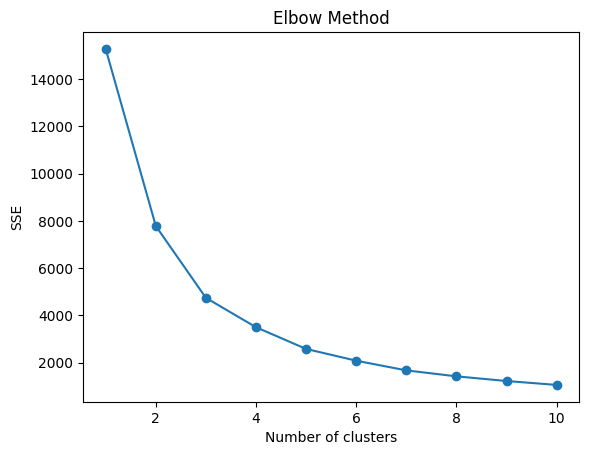

KeyboardInterrupt: 

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 엘보우 방법
sse = []
for k in range(1, 11):  # 예를 들어 1부터 10까지의 클러스터 수를 시도
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_pca)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

# 실루엣 점수
sil_scores = []
cluster_range = range(2, 11)  # 실루엣 점수는 최소 2개의 클러스터부터 계산 가능
for k in cluster_range:
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(df_pca)
    sil_score = silhouette_score(df_pca, cluster_labels)
    sil_scores.append(sil_score)

plt.plot(cluster_range, sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()


In [20]:
# 최적의 클러스터 수를 사용하여 KMeans 클러스터링 수행
optimal_clusters =8
kmeans = KMeans(n_clusters=optimal_clusters)
cluster_labels = kmeans.fit_predict(df_pca)

# 각 빌딩의 클러스터 레이블 평균 계산
num_points_per_building = 2040
num_buildings = len(cluster_labels) // num_points_per_building
building_cluster_avg = []

for i in range(num_buildings):
    start_idx = i * num_points_per_building
    end_idx = start_idx + num_points_per_building
    avg_label = np.mean(cluster_labels[start_idx:end_idx])
    building_cluster_avg.append(round(avg_label))

# 각 빌딩의 클러스터 할당 결과 출력
for i, cluster in enumerate(building_cluster_avg):
    print(f"Building {i+1}: Cluster {cluster}")

Building 1: Cluster 2
Building 2: Cluster 1
Building 3: Cluster 2
Building 4: Cluster 3
Building 5: Cluster 4
Building 6: Cluster 1
Building 7: Cluster 3
Building 8: Cluster 3
Building 9: Cluster 3
Building 10: Cluster 4
Building 11: Cluster 1
Building 12: Cluster 2
Building 13: Cluster 0
Building 14: Cluster 0
Building 15: Cluster 1
Building 16: Cluster 4
Building 17: Cluster 2
Building 18: Cluster 1
Building 19: Cluster 2
Building 20: Cluster 4
Building 21: Cluster 4
Building 22: Cluster 2
Building 23: Cluster 2
Building 24: Cluster 3
Building 25: Cluster 4
Building 26: Cluster 3
Building 27: Cluster 1
Building 28: Cluster 3
Building 29: Cluster 2
Building 30: Cluster 3
Building 31: Cluster 2
Building 32: Cluster 5
Building 33: Cluster 5
Building 34: Cluster 0
Building 35: Cluster 0
Building 36: Cluster 0
Building 37: Cluster 4
Building 38: Cluster 3
Building 39: Cluster 3
Building 40: Cluster 3
Building 41: Cluster 3
Building 42: Cluster 3
Building 43: Cluster 3
Building 44: Cluster

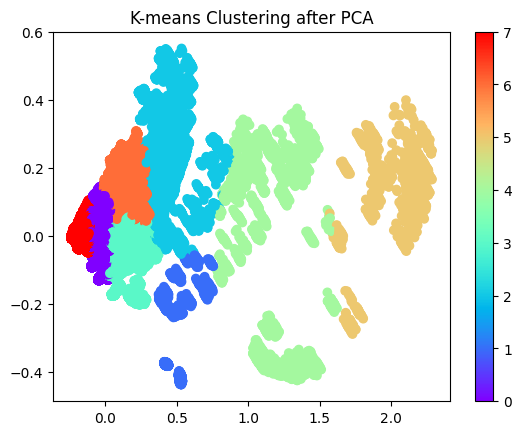

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA로 차원 축소 (2차원으로)
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_minmax)

# K-means 클러스터링
kmeans = KMeans(n_clusters=8) 
clusters = kmeans.fit_predict(df_pca)

# 결과 시각화
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='rainbow')
plt.title('K-means Clustering after PCA')
plt.colorbar()
plt.show()
